# Storm Damage Severity Modeling (Texas, 2010–2025)

This notebook trains classification models to predict whether a storm
event will result in high economic damage (≥ $1M), using event-level
features from NOAA Storm Events data.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_parquet("../data/interim/tx_2010_2025.parquet")

df["high_damage"] = (df["TOTAL_DAMAGE_USD"] >= 1_000_000).astype(int)

df["high_damage"].value_counts(normalize=True)


high_damage
0    0.986883
1    0.013117
Name: proportion, dtype: float64

## Baseline Model Performance

As a baseline, we evaluate a naive classifier that predicts **all storm
events as low damage**. This reflects the strong class imbalance in the
dataset and provides a lower bound for model performance.

While this baseline achieves high overall accuracy, it fails to identify
any high-damage events, making it unsuitable for risk prediction.



In [ ]:
from sklearn.metrics import classification_report

y = df["high_damage"]

y_pred_baseline = [0] * len(y)

print(classification_report(y, y_pred_baseline, digits=3))


              precision    recall  f1-score   support

           0      0.987     1.000     0.993     75390
           1      0.000     0.000     0.000      1002

    accuracy                          0.987     76392
   macro avg      0.493     0.500     0.497     76392
weighted avg      0.974     0.987     0.980     76392



/home/cristian/code/tx-storm-impact-analyzer/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cristian/code/tx-storm-impact-analyzer/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cristian/code/tx-storm-impact-analyzer/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

## Train/Test Split and Feature Setup

We split the data into training and test sets using a **stratified split**
to preserve the rare high-damage class distribution. We then build a
pipeline that one-hot encodes categorical features and trains a
class-weighted Logistic Regression model.


In [3]:
from sklearn.model_selection import train_test_split


y = df["high_damage"]

feature_cols = [
    "EVENT_TYPE",
    "CZ_TYPE",
    "CZ_NAME",
    "SOURCE",
    "MAGNITUDE",
    "INJURIES_DIRECT",
    "INJURIES_INDIRECT",
    "DEATHS_DIRECT",
    "DEATHS_INDIRECT",
    "BEGIN_MONTH",
]

X = df[feature_cols].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

y_train.mean(), y_test.mean()


(np.float64(0.013123230736504508), np.float64(0.013089861901956934))

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

cat_cols = ["EVENT_TYPE", "CZ_TYPE", "CZ_NAME", "SOURCE"]
num_cols = ["MAGNITUDE", "INJURIES_DIRECT", "INJURIES_INDIRECT", "DEATHS_DIRECT", "DEATHS_INDIRECT", "BEGIN_MONTH"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",   
    n_jobs=None
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model)
])

clf.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test)

print(
    classification_report(
        y_test,
        y_pred,
        target_names=["Low Damage", "High Damage"],
        digits=3,
        zero_division=0
    )
)



cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(
    cm,
    index=["Actual Low Damage", "Actual High Damage"],
    columns=["Predicted Low Damage", "Predicted High Damage"]
)

cm_df


              precision    recall  f1-score   support

  Low Damage      0.997     0.810     0.894     15079
 High Damage      0.053     0.800     0.099       200

    accuracy                          0.810     15279
   macro avg      0.525     0.805     0.496     15279
weighted avg      0.984     0.810     0.883     15279



,Predicted Low Damage,Predicted High Damage
Actual Low Damage,12212,2867
Actual High Damage,40,160


### Interpretation

The Logistic Regression model successfully identifies the majority of
high-damage storm events, achieving a recall of approximately 80%.
However, this comes at the cost of increased false positives, which is
expected in highly imbalanced classification problems.

This tradeoff is acceptable in risk-focused applications where missing
high-impact events is more costly than false alarms.


## Random Forest Model

To capture non-linear relationships and interactions between features,
we train a Random Forest classifier. This model is well-suited for
tabular data and often improves precision while maintaining strong
recall on imbalanced problems.


In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_clf = Pipeline(steps=[
    ("preprocess", preprocess), 
    ("model", rf)
])

rf_clf.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_rf = rf_clf.predict(X_test)

print(
    classification_report(
        y_test,
        y_pred_rf,
        target_names=["Low Damage", "High Damage"],
        digits=3,
        zero_division=0
    )
)

cm_rf = confusion_matrix(y_test, y_pred_rf)

pd.DataFrame(
    cm_rf,
    index=["Actual Low Damage", "Actual High Damage"],
    columns=["Predicted Low Damage", "Predicted High Damage"]
)


              precision    recall  f1-score   support

  Low Damage      0.996     0.914     0.953     15079
 High Damage      0.102     0.740     0.180       200

    accuracy                          0.912     15279
   macro avg      0.549     0.827     0.566     15279
weighted avg      0.985     0.912     0.943     15279



,Predicted Low Damage,Predicted High Damage
Actual Low Damage,13780,1299
Actual High Damage,52,148


In [11]:
from sklearn.metrics import precision_recall_fscore_support

def summarize_model(y_true, y_pred, label):
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    return {
        "model": label,
        "precision": round(p, 3),
        "recall": round(r, 3),
        "f1": round(f1, 3),
    }

summary = pd.DataFrame([
    summarize_model(y_test, y_pred, "Logistic Regression"),
    summarize_model(y_test, y_pred_rf, "Random Forest"),
])

summary


,model,precision,recall,f1
0,Logistic Regression,0.053,0.80,0.099
1,Random Forest,0.102,0.74,0.180


In [12]:
ohe = rf_clf.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

feature_names = list(cat_feature_names) + num_cols
importances = rf_clf.named_steps["model"].feature_importances_

fi = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .head(15)
)

fi


,feature,importance
493,MAGNITUDE,0.133617
498,BEGIN_MONTH,0.054745
476,SOURCE_NWS Storm Survey,0.047754
284,CZ_NAME_LUBBOCK,0.032351
31,EVENT_TYPE_Thunderstorm Wind,0.023464
17,EVENT_TYPE_Heat,0.022566
467,SOURCE_Emergency Manager,0.019573
496,DEATHS_DIRECT,0.018444
341,CZ_NAME_POTTER,0.017962
478,SOURCE_Official NWS Observations,0.017272


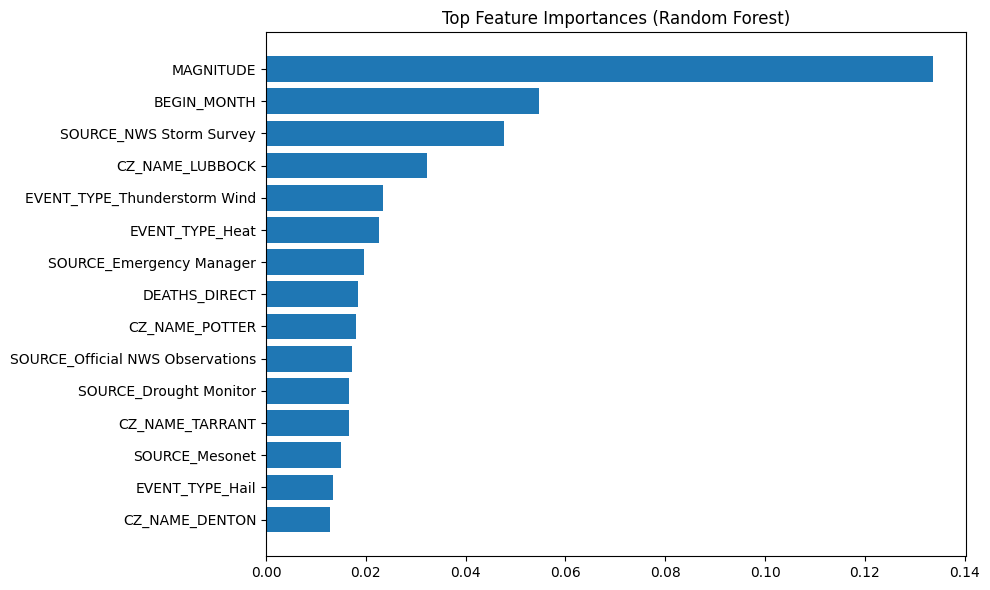

In [15]:
import os
import matplotlib.pyplot as plt

FIG_DIR = "../reports/figures"
os.makedirs(FIG_DIR, exist_ok=True)

fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(fi["feature"], fi["importance"])
ax.set_title("Top Feature Importances (Random Forest)")
ax.invert_yaxis()

fig.tight_layout()
fig.savefig(f"{FIG_DIR}/random_forest_feature_importance.png", dpi=150)
plt.show()


## Model Comparison and Interpretation

Both models significantly outperform the naive baseline by identifying
high-damage storm events in a highly imbalanced dataset.

Logistic Regression achieved higher recall (80%), successfully capturing
most high-damage events, but produced a large number of false positives,
resulting in low precision. This behavior is expected from a linear,
class-weighted model optimized for sensitivity.

The Random Forest model improved precision (from 5.3% to 10.2%) and nearly
doubled the F1 score, indicating a better balance between precision and
recall. However, this improvement came at the cost of slightly reduced
recall, with more high-damage events missed compared to Logistic
Regression.

These results highlight an important tradeoff in risk-focused modeling:
models optimized for maximum recall may generate many false alarms, while
more selective models reduce false positives but may miss some extreme
events. The choice between models depends on the relative cost of missed
events versus false alerts.
